<a href="https://colab.research.google.com/github/IFuentesSR/RSE_drought/blob/main/gamma_standardisation_indices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import, authenticate and initialize the Earth Engine library.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=XaPhiMSLdo6NpbgI2C0rV4PG8kYNCQiw1Qu-h77F3nQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g47XV5_X6qI2BDbOMe4bpUn1pZDP9NYz1Nse2nEXDVwLO_mxVpncFk

Successfully saved authorization token.


### Importing libraries

In [ ]:
# Folium setup.
import folium
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

print(folium.__version__)

0.8.3


### Functions for gamma distribution and normal conversion of standardised indices

In [ ]:
def gammaf(img, alpha, beta):
    g_alpha = ee.Image(alpha).gamma()
    inc = ee.Image(img).divide(beta).gammainc(alpha)
    dist = img.where(ee.Image(img).lte(0), 0)
    return dist.where(ee.Image(dist).gt(0), inc)


def cummProbf(gamma, q):
    return q.add((ee.Image(1).subtract(q)).multiply(gamma))


def normInv(cummProb):
     return cummProb.multiply(2).subtract(1).erfInv().multiply(ee.Image(2).sqrt())


def conditional_clean(collection, month, month_lag):
    def inner(year):
        date = ee.Date.fromYMD(year, month, 1)
        condition = ee.Algorithms.If(ee.ImageCollection(collection.filterDate(date.advance(ee.Number(month_lag).multiply(-1), 'month'), date)).size().eq(0),
                                     ee.Image().set({'drop':1}),
                                     ee.ImageCollection(collection.filterDate(date.advance(ee.Number(month_lag).multiply(-1), 'month'), date)).sum().set({'drop':0}))
        return ee.Image(condition)
    return inner


def zero_mask(img):
    return ee.Image(img).updateMask(ee.Image(img).gt(0))


def zero_gt(img):
    return ee.Image(img).gt(0)


def img_log(img):
    return ee.Image(img).log()


def gamma_params(collection, month, month_lag):
    year_start = ee.Date(ee.Image(collection.first()).get('system:time_start')).get('year')
    year_end = ee.Date(ee.Image(collection.toList(10000).get(-1)).get('system:time_start')).get('year')
    years = ee.List.sequence(1981, 2019)
    filteredColl = years.map(conditional_clean(collection, month, month_lag))
    filteredColl = ee.ImageCollection.fromImages(filteredColl.filter(ee.Filter.eq('drop', 0)))
    nonzeros = filteredColl.map(zero_mask)
    average = ee.ImageCollection(nonzeros).mean()
    sumLogs = ee.ImageCollection(nonzeros.map(img_log)).sum()
    sizeNonZeros = ee.ImageCollection(filteredColl.map(zero_gt)).sum()
    A = average.log().subtract(sumLogs.divide(sizeNonZeros))
    alpha = ee.Image(1).divide(A.multiply(4)).multiply(A.multiply(4 / 3).add(1).sqrt().add(1)).rename('alpha')
    beta = average.divide(alpha).rename('beta')
    q = (ee.Image(filteredColl.size()).subtract(sizeNonZeros)).divide(ee.Image(filteredColl.size())).rename('q')
    return alpha.addBands([beta, q]).set({'month': month})


def standardised_index_function(collection, month, year, scale):
    params = gamma_params(collection, month, scale)
    img = collection.filterDate(ee.Date.fromYMD(year, month, 1).advance(ee.Number(scale).multiply(-1), 'month'),
                                ee.Date.fromYMD(year, month, 1)).sum()
    gamma = gammaf(img, ee.Image(params).select('alpha'), ee.Image(params).select('beta'))
    gammaP = cummProbf(gamma, ee.Image(params).select('q'))
    standardised_index = normInv(gammaP.toDouble()).set({'system:time_start': ee.Date.fromYMD(year, month, 1).millis(), 
                                                         'system:index':ee.Date.fromYMD(year, month, 1).format('YYYY_MM_dd')})
    return standardised_index



### Import collection and conversion of rainfall images into mm if needed

In [ ]:
def gpm_monthly_rain(img):
    date_start = ee.Date(img.get('system:time_start'))
    date_end = date_start.advance(1, 'month')
    days = date_end.difference(date_start, 'day')
    return img.multiply(ee.Image(days)).multiply(24).copyProperties(img, ['system:time_start', 'system:time_end'])


collection = ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V06").select('precipitation').map(gpm_monthly_rain)

### Definition of parameters 

In [ ]:
start_year = ee.Date(collection.first().get('system:time_start')).get('year')
end_year = ee.Date(ee.Image(collection.toList(10000).get(-1)).get('system:time_start')).get('year')
years = ee.List.sequence(start_year, end_year)
months = ee.List.sequence(1,12)
scale = 3 #monthly accumulation
geo1 = ee.Geometry.Point([149.981, -30.468])

### Standardised index for single date and mapping of image for 2019-07-01

In [ ]:
SI_test = standardised_index_function(collection, 7, 2019, 3)

In [ ]:
mapidCon = ee.Image(SI_test).getMapId({'min': -3, 'max': 3, 'palette': 'FF0000, FFFFFF, 0000FF', 'opacity':0.4})
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='ETr',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Functions to apply Standardisation to entire collection

In [ ]:
def condition(collection, month, year, scale):
    condition = ee.Algorithms.If(collection.filterDate(ee.Date.fromYMD(year, month, 1).advance(ee.Number(scale).multiply(-1), 'month'), 
                                                   ee.Date.fromYMD(year, month, 1)).size().eq(0),
                                 ee.Image().set({'drop':1}),
                                 ee.Image(standardised_index_function(collection, month, year, scale)).set({'drop':0}))
    return ee.Image(condition)


def monthly_calcul(collection, year, scale):
    months = ee.List.sequence(1, 12)
    def inner(month):
        conditional = condition(collection, month, year, scale)
        return conditional
    return months.map(inner)


def out_wrap(collection, scale):
    def inner(year):
        return monthly_calcul(collection, year, scale)
    return inner


### Generation of standardised collection 

In [ ]:
standardised_index_collection = years.map(out_wrap(collection, scale))
standardised_index_collection = standardised_index_collection.flatten()
standardised_index_collection = ee.ImageCollection.fromImages(standardised_index_collection.filter(ee.Filter.eq('drop', 0))).sort('system:time_start')

In [ ]:
mapidCon = ee.Image(standardised_index_collection.filterDate('2019-07-01', '2021-12-31').first()).getMapId({'min': -3, 'max': 3, 'palette': 'FF0000, FFFFFF, 0000FF', 'opacity':0.4})
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='ETr',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Sampling collection in specific location

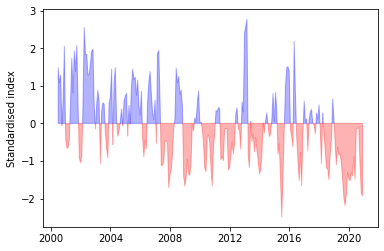

In [ ]:
def sample_location(geometry):
    def inner(img):
        date = img.get('date')
        index = img.reduceRegion('first', geometry, 10000).values().get(0)
        return ee.Feature(None, {'ix':index})
    return inner


geo2 = ee.Geometry.Point([-71.42, -34.67])
series = standardised_index_collection.map(sample_location(geo2))
series = series.getInfo()
ixs = [n['properties']['ix'] for n in series['features']]
time = [pd.to_datetime(n['id'], format='%Y_%m_%d') for n in series['features']]
df = pd.DataFrame(data={'ix':ixs, 'date':time})
d = np.zeros(len(ixs))

fig, axs = plt.subplots()
axs.fill_between(time, d, ixs, where=df['ix']>=d, interpolate=True, color='blue', alpha=0.3, label='SVI')
axs.fill_between(time, d, ixs, where=df['ix']<=d, interpolate=True, color='red', alpha=0.3)
axs.set_ylabel('Standardised index')
fig.show()

### Exporting collection for further analysis as multiband image

The following analysis may lead to memory errors if the collection is not stored

In [ ]:
def rename_bands(current, previous):
    return ee.List(previous).add(ee.String('SI3').cat(ee.Date(current.get('system:time_start')).format('YYYY_MM_dd')))

contour = ee.Geometry.Polygon(
        [[[-142.35313606222832, 73.12592026591842],
          [-142.35313606222832, -57.889711960715694],
          [169.13123893777166, -57.889711960715694],
          [169.13123893777166, 73.12592026591842]]],
          None,
          False)

bands = standardised_index_collection.iterate(rename_bands, ee.List([]))
multiBand_img = standardised_index_collection.toBands().rename(bands)
ee.batch.Export.image.toAsset(image=multiBand_img,
                              scale=10000,
                              region=contour,
                              maxPixels=1e13,
                              description='SI3_GPM',
                              assetId='users/change_to_your_user/SI3_GPM').start()

### Loading stored multiband image

In [ ]:
img_si = ee.Image('users/ignaciofuentessanroman/SI3_GPM')
bands = img_si.bandNames()


### Defining functions for drought characterization

In [ ]:
def drought_preprocess(collection):
    def wrap(current, previous):
        string = ee.String(current).slice(3).replace('_', '-').replace('_', '-')
        date = ee.Date(string)
        next_month = date.advance(1, 'month').format('YYYY_MM_dd')
        next_band = ee.String('SI3').cat(next_month)
        next = collection.select(next_band).rename('SI3')
        masked_next = next.lt(-1).rename('MASK')
        next = next.addBands(masked_next)
        img = collection.select(ee.String(current)).rename('SI3')
        masked_current = img.lt(-1).rename('MASK')
        current = img.addBands(masked_current)
        pre = ee.Image(ee.List(previous).get(-1))
        cum = ee.Image(0).addBands(ee.Image(0))
        cum = cum.where(current.select('MASK').neq(0),
                        pre.add(current)).rename(['SI3', 'MASK'])
        cum = cum.setMulti({'system:time_start': date.millis(),
                            'system:index': string})
        return ee.List(previous).add(cum)
    return wrap


def filtering(collection):
    def inner(date):
        current = collection.filterDate(ee.Date(date),
                                        ee.Date(date).advance(15, 'day')).first()
        next = collection.filterDate(ee.Date(date).advance(1, 'month'),
                                     ee.Date(date).advance(45, 'day')).first()
        keep = ee.Image(0).addBands(ee.Image(0)).where(current.select('MASK').gt(0).And(next.select('MASK').eq(0)),
                                                    current).rename(['SI3', 'MASK'])
        return keep.copyProperties(current,
                                   ['system:time_start', 'system:index'])
    return inner


def mask(img):
    date = ee.Date(img.get('system:time_start'))
    days = date.advance(1, 'month').difference(date, 'days')
    time = ee.Image(date.millis().divide(1000*86400).divide(days)).rename('time')
    img = img.addBands(time)
    return img.updateMask(img.select('MASK').neq(0)).toFloat().copyProperties(img,['system:time_start', 'system:index'])


def abs(img):
    return img.abs().copyProperties(img,
                                    ['system:time_start', 'system:index'])


def ratio(img):
    return img.select('SI3').abs().divide(img.select('MASK')).copyProperties(img,
                                                                              ['system:time_start', 'system:index'])



### Drought characterisation steps and conversion into collection

In [ ]:
last = ee.Date(ee.String(bands.get(-1)).slice(3).replace('_', '-').replace('_', '-')).advance(1, 'month')
last_string = last.format('YYYY_MM_dd')
last_string = ee.String('SI3').cat(last_string)
img_si = img_si.addBands(ee.Image(-1).rename(last_string))

drought_pre = bands.iterate(drought_preprocess(img_si), ee.List([ee.Image(0)]))
drought_pre = ee.List(drought_pre).slice(1)
drought_pre = ee.ImageCollection.fromImages(drought_pre).sort('system:time_start')
dates = drought_pre.aggregate_array('system:time_start')

remanent = ee.Image(0).addBands(ee.Image(0)).rename(['SI3', 'MASK']).set('system:time_start', last.millis())
drought_pre = drought_pre.merge(ee.ImageCollection(remanent))
drought_pre = ee.ImageCollection.fromImages(dates.map(filtering(drought_pre)))

In [ ]:
drought_pre.map(mask).filterDate('1984-01-01', '2020-02-01').first().getInfo()

{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'precision': 'float', 'type': 'PixelType'},
   'id': 'SI3'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'precision': 'float', 'type': 'PixelType'},
   'id': 'MASK'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'precision': 'float', 'type': 'PixelType'},
   'id': 'time'}],
 'properties': {'system:index': '1_2000-07-01',
  'system:time_start': 962409600000},
 'type': 'Image'}

### Generation of duration-severity-intensity images

In [ ]:
duration = drought_pre.map(mask)
duration_mean = duration.select('MASK').sum().divide(duration.select('MASK').count())

severity = drought_pre.map(mask).select('SI3').map(abs)
severity_mean = severity.mean()

intensity = drought_pre.map(mask).map(ratio)
intensity_mean = intensity.mean()

### Mapping average drought characteristics

In [ ]:
mapid_dur = ee.Image(duration_mean).getMapId({'min': 0, 'max': 10, 'palette': '0000FF, 00FFFF, 00FF00, FFFF00, FF0000', 'opacity':0.6})
mapid_sev = ee.Image(severity_mean).getMapId({'min': 0, 'max': 7, 'palette': '0000FF, 00FFFF, 00FF00, FFFF00, FF0000', 'opacity':0.6})
mapid_int = ee.Image(intensity_mean).getMapId({'min': 0, 'max': 1, 'palette': '0000FF, 00FFFF, 00FF00, FFFF00, FF0000', 'opacity':0.6})

centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=mapid_dur['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='mean_duration',
  ).add_to(map)
folium.TileLayer(
    tiles=mapid_sev['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='mean_severity',
  ).add_to(map)
folium.TileLayer(
    tiles=mapid_int['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='mean_intensity',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Trend analysis of durations 

In [ ]:
ols = ee.Reducer.linearFit()
duration_trend = duration.select(['time', 'MASK']).reduce(ols).select('scale')

pearson = ee.Reducer.pearsonsCorrelation()
pvalue = duration.select(['time', 'MASK']).reduce(pearson).select('p-value')

### Maping drought duration trends and significance

In [ ]:
map_dur_trend = ee.Image(duration_trend).getMapId({'min': -0.1, 'max': 0.1, 'palette': '0000FF, FFFFFF, FF0000', 'opacity':1})
map_dur_significance = ee.Image(pvalue).getMapId({'min': 0, 'max': 0.1, 'palette': 'FF0000, FFFFFF', 'opacity':0.6})
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=map_dur_significance['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='significance_trend',
).add_to(map)
folium.TileLayer(
    tiles=map_dur_trend['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='duration_trend',
).add_to(map)
map.add_child(folium.LayerControl())
map